<h1 style="text-align: center;"><strong>Report</strong></h1>


### IMPORT

In [61]:
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

from _data_manager import DataManager
from _trade import Trade
from _long_short_trade import TradeLongShort
from _backtesting import Backtest
from _strategy_linear_regression import StrategyLinearRegression, StrategyLinearRegressionMultiAgent
from _strategy_cross_yield import StrategyCrossYield
from _trade_filter import TradeFilter
from _strategy_comparator import StratgiesComparetor
from _strategy_linear_optimisation_time import AssetSelectioByModel, OptimisationTimeRegressison




In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Option d'affichage


In [63]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore')



# DATA ANALYSIS

To work efficiently with data, I created the `DataManager` class. This class streamlines the necessary transformations for analyzing bond yields. It loads the data, organizes it by date, country, and maturity, and calculates key statistics such as ranks, yield spreads, averages, and rolling standard deviations, thereby enabling a thorough and comparative analysis of bond performance.

In [64]:
file_path = 'EGB_historical_yield.csv'
data_manager = DataManager(file_path)


In [65]:
data_manager.data.shape

(2110, 21)

In [66]:
data_manager.data.head()

Germany_5y  Germany_10y  Germany_30y  Belgium_5y  Belgium_10y  \
date                                                                        
2016-01-15       -16.4         53.9        131.2        -2.1         83.8   
2016-01-18       -16.6         53.6        131.2        -3.3         83.5   
2016-01-19       -16.7         54.8        132.2        -4.1         84.0   
2016-01-20       -19.8         48.1        122.5        -6.0         96.3   
2016-01-21       -24.0         44.9        121.4        -9.8         91.5   

            Belgium_30y  Austria_5y  Austria_10y  Austria_30y  Netherlands_5y  \
date                                                                            
2016-01-15        189.7          -8         77.7        160.4           -10.4   
2016-01-18        190.0          -8         77.4        160.7           -10.6   
2016-01-19        189.9          -8         78.3        161.8           -11.3   
2016-01-20        184.2         -11         73.2        153.1           -13.8   
2016-01-21        180.5         -16         69.6        153.0           -18.2   

            Netherlands_10y  Netherlands_30y  France_5y  France_10y  \
date                                                                  
2016-01-15             66.1            143.6      -10.4        66.1   
2016-01-18             66.0            143.9      -10.6        66.0   
2016-01-19             66.1            145.1      -11.3        66.1   
2016-01-20             60.9            135.9      -13.8        60.9   
2016-01-21             57.0            134.8      -18.2        57.0   

            France_30y  Spain_5y  Spain_10y  Spain_30y  Italy_5y  Italy_10y  \
date                                                                          
2016-01-15       143.6      65.4      175.0      291.2      56.1      156.4   
2016-01-18       143.9      64.0      174.0      291.5      56.6      156.4   
2016-01-19       145.1      60.5      170.1      288.2      55.3      155.7   
2016-01-20       135.9      65.7      178.2      296.7      62.2      164.9   
2016-01-21       134.8      60.2      171.9      291.5      54.4      156.1   

            Italy_30y  
date                   
2016-01-15      264.9  
2016-01-18      266.9  
2016-01-19      265.2  
2016-01-20      275.9  
2016-01-21      269.5

In [67]:
data_manager.data.dtypes

Germany_5y         float64
Germany_10y        float64
Germany_30y        float64
Belgium_5y         float64
Belgium_10y        float64
Belgium_30y        float64
Austria_5y           int64
Austria_10y        float64
Austria_30y        float64
Netherlands_5y     float64
Netherlands_10y    float64
Netherlands_30y    float64
France_5y          float64
France_10y         float64
France_30y         float64
Spain_5y           float64
Spain_10y          float64
Spain_30y          float64
Italy_5y           float64
Italy_10y          float64
Italy_30y          float64
dtype: object

For the Austria 5-year rates, we only have `int64` data types, which likely indicates a lack of precision in this measurement compared to others. Given 2110 rows, the probability of having only integer numbers is virtually zero.

In [68]:
data_manager.data.isnull().sum().sort_values().head(3)

Germany_5y    0
Italy_5y      0
Spain_30y     0
dtype: int64

There are no missing data, which is good news.

In [69]:
data_manager.data.describe()

Germany_5y  Germany_10y  Germany_30y   Belgium_5y  Belgium_10y  \
count  2110.000000  2110.000000  2110.000000  2110.000000  2110.000000   
mean     11.990521    47.930995    94.990332    31.534313    88.705403   
std     110.244206    97.853356    84.547229   116.515992   109.453098   
min     -99.100000   -85.800000   -49.300000   -72.400000   -43.600000   
25%     -58.500000   -26.275000    24.000000   -43.275000     7.200000   
50%     -35.400000    25.100000    90.850000   -19.650000    64.700000   
75%       4.050000    61.125000   127.550000    22.300000    95.750000   
max     289.100000   296.600000   320.600000   324.400000   362.800000   

       Belgium_30y   Austria_5y  Austria_10y  Austria_30y  Netherlands_5y  \
count  2110.000000  2110.000000  2110.000000  2110.000000     2110.000000   
mean    165.658104    29.082938    79.211185   135.861327       18.575592   
std      96.159139   119.676026   112.184716    93.752196      116.077422   
min      26.400000   -76.000000   -48.500000    -6.600000      -86.800000   
25%      84.825000   -44.000000    -2.575000    56.200000      -52.800000   
50%     160.600000   -25.000000    49.500000   132.500000      -32.200000   
75%     185.075000    14.000000    80.775000   157.800000       -2.550000   
max     418.800000   332.000000   358.400000   379.100000      313.000000   

       Netherlands_10y  Netherlands_30y    France_5y   France_10y  \
count      2110.000000      2110.000000  2110.000000  2110.000000   
mean         66.287488       104.963886    18.575592    66.287488   
std         104.988257        90.751273   116.077422   104.988257   
min         -65.200000       -38.100000   -86.800000   -65.200000   
25%         -12.275000        28.600000   -52.800000   -12.275000   
50%          41.450000        99.350000   -32.200000    41.450000   
75%          73.675000       131.000000    -2.550000    73.675000   
max         331.100000       344.600000   313.000000   331.100000   

        France_30y     Spain_5y    Spain_10y    Spain_30y     Italy_5y  \
count  2110.000000  2110.000000  2110.000000  2110.000000  2110.000000   
mean    104.963886    69.074645   145.899763   236.917393   135.596066   
std      90.751273   116.066133   106.837146    97.354064   127.540894   
min     -38.100000   -45.700000    -1.900000    79.600000   -12.600000   
25%      28.600000   -13.400000    46.650000   136.625000    36.425000   
50%      99.350000    29.050000   140.150000   251.050000    78.050000   
75%     131.000000    61.675000   169.075000   288.275000   212.850000   
max     344.600000   368.300000   406.600000   469.100000   435.100000   

         Italy_10y    Italy_30y  
count  2110.000000  2110.000000  
mean    219.323081   301.104076  
std     120.103048    96.317931  
min      45.500000   138.200000  
25%     121.650000   220.900000  
50%     196.100000   302.650000  
75%     298.525000   361.925000  
max     497.900000   544.200000

In [70]:
data_manager.data.std(axis=0).sort_values()

Germany_30y         84.547229
France_30y          90.751273
Netherlands_30y     90.751273
Austria_30y         93.752196
Belgium_30y         96.159139
Italy_30y           96.317931
Spain_30y           97.354064
Germany_10y         97.853356
France_10y         104.988257
Netherlands_10y    104.988257
Spain_10y          106.837146
Belgium_10y        109.453098
Germany_5y         110.244206
Austria_10y        112.184716
Spain_5y           116.066133
France_5y          116.077422
Netherlands_5y     116.077422
Belgium_5y         116.515992
Austria_5y         119.676026
Italy_10y          120.103048
Italy_5y           127.540894
dtype: float64

Long-term bonds are generally less volatile than short-term ones, but there are some exceptions, such as the 5-year German bond (which is in the 10-year group), or Italy 10-year, which is the second most volatile bond. This indicates higher uncertainty for Italy and lower uncertainty for Germany, which is more stable. Interestingly, the order by maturity is roughly but not always consistent (such as with Spain for the 5-year rate, which is second vs. last for the 30-year rate).

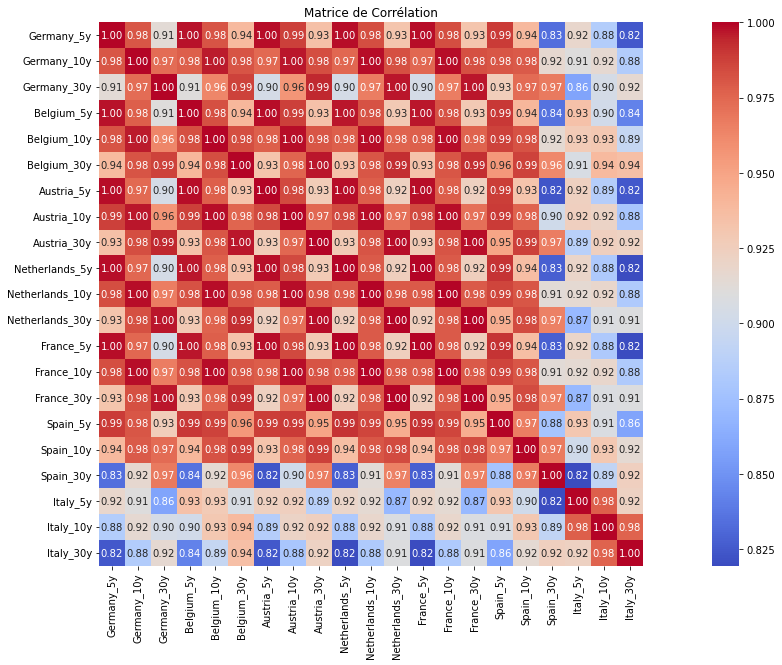

In [71]:
corr = data_manager.data.corr()

plt.figure(figsize=(25, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Matrice de Corrélation')
plt.show()

The set is highly correlated, with Italy appearing to be significantly less correlated than other nations with each other. It is observed that in many instances, countries with equal maturity have almost perfect correlations.

# **Dashboard**

The best way to understand data is to have the ability to view and navigate through it easily, which is why I decided to create a complete interactive dashboard to thoroughly comprehend it. Indeed, the fixed income field is not very familiar to me, and being able to understand the data I work with is very important. To view the data, launch the **_dashboard.py** file, which offers numerous data visualizations.

Here is the url of the dashboard once launched : http://127.0.0.1:8050/

# **Backtesting Framework**

To evaluate strategies, I needed a backtester. Given that the P&L of yields follows a specific logic, I had to code a backtester from scratch. However, since the P&L logic is somewhat opposite to that of equity, I could have simply inverted the yields and used a standard backtester to avoid reinventing the wheel. Nonetheless, I decided to create a framework from scratch to gain flexibility and avoid being slowed down by learning how to use a backtesting library, which is not the objective of this exercise.

I have two classes that facilitate the execution of trades:
- `Trade`: This class models a financial operation, enabling the calculation and tracking of daily profit and loss (P&L) for an asset over a given period.
- `TradeLongShort`: This class implements a trading strategy of being long on one asset and short on another when two indices cross, calculating and tracking the daily P&L for the specified period.

Then, for backtesting, I have a class that accounts for a list of Trades:
- The `Backtest` class is designed to execute a backtest of trading strategies, consolidating the profit and loss (P&L) data from multiple trades provided in a list and visualizing them with a chart. It includes preparing the P&L data for each trade, calculating the total P&L over the backtest period, and a lot of methods for evaluating backtest performance, such as the Sharpe ratio, total return, and the percentage of winning trades...

# **Strategy 1 : cross yield**

I observe a mean-reverting behavior; notably, when inspecting visually, it becomes apparent that whenever two yields intersect, they tend to intersect once more at a later point. This observation motivates the exploration of a strategy that entails initiating a long-short position upon the yields' intersection and subsequently exiting the position when they intersect again.

The question at hand was how to generate these signals. Initially, I embarked on a very complex approach, but then I develop a simpler solution. This simpler solution involves taking the yield spread of each pair of yields. Thus, when the yield changes from negative to positive (or vice versa), it indicates that the yields have crossed each others.

The `StrategyCrossYield` class detects sign changes in yield spreads to generate trading signals, maintaining positions based on yield intersections and incorporating stop-loss strategies. 

The `TradeCreationLongShort` class processes these signals to create and manage a list of long-short trades, considering holding periods and stop-loss parameters.

### **Results**

First, the initial factor I need to consider in this strategy is the duration for which the trade remains open. Indeed, in real life, it's uncertain if the yields will intersect again, so it's crucial to set a maximum date to exit the trade, even if the yields do not cross.

In [72]:
data_spread_yield = data_manager.spread_yield
time_to_keep_the_asset_if_not_cross = [5,10,20,40,60,80]
stop_loss = None

In [73]:
list_of_strategy = []
list_of_strategy_name = []
for time_to_keep_if_not_cross in time_to_keep_the_asset_if_not_cross:
    cross_strategy = StrategyCrossYield(data_spread_yield,time_to_keep_if_not_cross, stop_loss)
    liste_trades = cross_strategy.execution_of_strategy()
    
    title = f"Profit and Loss Over Time - {time_to_keep_if_not_cross} days - Cross Strategy"
    backtest_cross_strategy = Backtest(liste_trades, data_manager.data)
    backtest_cross_strategy.gather_all_trades()
    backtest_cross_strategy.plot_p_and_l(title)
    list_of_strategy.append(backtest_cross_strategy)
    list_of_strategy_name.append(f"{time_to_keep_if_not_cross} days")


In [74]:
comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

5 days              10 days  \
Sharp Ratio                             0.07                 0.17   
Total Return                           248.9                624.5   
Percentage Win Trade                   0.575                0.597   
Number of Trades                        1542                 1384   
Worst Drawdown                       -1218.5              -1200.1   
Date of Worst Drawdown   2018-05-29 00:00:00  2018-05-29 00:00:00   
Annual Performance 2016                -39.6                 81.3   
Annual Performance 2017                 10.3                105.6   
Annual Performance 2018               -112.9               -126.8   
Annual Performance 2019                 20.7                 24.4   
Annual Performance 2020               -139.9               -145.0   
Annual Performance 2021                -32.4                -24.3   
Annual Performance 2022                471.7                514.6   
Annual Performance 2023                 33.3                151.1   
Annual Performance 2024                 32.5                 34.9   

                                     20 days              40 days  \
Sharp Ratio                             0.49                 0.61   
Total Return                          1871.3               2398.6   
Percentage Win Trade                   0.667                0.721   
Number of Trades                        1257                 1197   
Worst Drawdown                       -1121.0              -1121.0   
Date of Worst Drawdown   2018-05-29 00:00:00  2018-05-29 00:00:00   
Annual Performance 2016                335.9                414.9   
Annual Performance 2017                118.9                 92.2   
Annual Performance 2018                101.4                 87.5   
Annual Performance 2019                116.7                 99.2   
Annual Performance 2020                203.5                290.5   
Annual Performance 2021                -10.0                 41.3   
Annual Performance 2022                695.4                792.5   
Annual Performance 2023                285.3                551.0   
Annual Performance 2024                 29.8                 29.8   

                                     60 days              80 days  
Sharp Ratio                             0.71                 0.77  
Total Return                          2864.9               3063.8  
Percentage Win Trade                   0.753                0.768  
Number of Trades                        1157                 1131  
Worst Drawdown                       -1049.7              -1049.7  
Date of Worst Drawdown   2018-05-29 00:00:00  2018-05-29 00:00:00  
Annual Performance 2016                422.5                446.6  
Annual Performance 2017                180.9                222.0  
Annual Performance 2018                184.0                184.0  
Annual Performance 2019                190.4                219.8  
Annual Performance 2020                393.6                446.6  
Annual Performance 2021                 58.0                 62.2  
Annual Performance 2022                846.0                855.6  
Annual Performance 2023                531.8                574.2  
Annual Performance 2024                 55.2                 55.2

We notice that this strategy manages to produce results over time. It is observed that the more time is allowed for positions to reach their potential, the better this strategy performs because there is a greater chance that order will be restored. Therefore, if one must stick to a strategy, it would be the 80-day (4 months) one. However, it is observed that this strategy experiences significant drawdowns, which are of very short duration before being erased.

To mitigate these drawdowns, we will implement a **stop-loss** feature.

In [75]:
data_spread_yield = data_manager.spread_yield
time_to_keep_the_asset_if_not_cross = [60,80]
stop_loss = [-20,-50,-100]

In [76]:
list_of_strategy = []
list_of_strategy_name = []
for stop in stop_loss:
    for time_to_keep_if_not_cross in time_to_keep_the_asset_if_not_cross:

        cross_strategy = StrategyCrossYield(data_spread_yield,time_to_keep_if_not_cross, stop)
        liste_trades = cross_strategy.execution_of_strategy()
        
        title = f"Profit and Loss Over Time - {time_to_keep_if_not_cross} days, {stop} stop loss - Cross Strategy"
        backtest_cross_strategy = Backtest(liste_trades, data_manager.data)
        backtest_cross_strategy.gather_all_trades()
        backtest_cross_strategy.plot_p_and_l(title)
        list_of_strategy.append(backtest_cross_strategy)
        list_of_strategy_name.append(f"{time_to_keep_if_not_cross} days, {stop} stop loss ")

In [77]:
comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

60 days, -20 stop loss  80 days, -20 stop loss   \
Sharp Ratio                                0.33                    0.32   
Total Return                              748.8                   704.5   
Percentage Win Trade                      0.709                   0.715   
Number of Trades                           1157                    1131   
Worst Drawdown                           -837.3                  -824.3   
Date of Worst Drawdown      2020-04-21 00:00:00     2020-04-21 00:00:00   
Annual Performance 2016                   286.5                   282.9   
Annual Performance 2017                   106.8                   120.3   
Annual Performance 2018                  -407.4                  -407.4   
Annual Performance 2019                    72.0                    51.8   
Annual Performance 2020                  -280.8                  -240.5   
Annual Performance 2021                    58.0                    62.2   
Annual Performance 2022                   499.1                   508.7   
Annual Performance 2023                   351.7                   267.7   
Annual Performance 2024                    55.2                    55.2   

                        60 days, -50 stop loss  80 days, -50 stop loss   \
Sharp Ratio                                 0.7                    0.81   
Total Return                             1795.7                  2061.4   
Percentage Win Trade                      0.742                   0.759   
Number of Trades                           1157                    1131   
Worst Drawdown                           -679.6                  -651.3   
Date of Worst Drawdown      2020-03-17 00:00:00     2018-05-29 00:00:00   
Annual Performance 2016                   422.5                   446.6   
Annual Performance 2017                   180.9                   222.0   
Annual Performance 2018                  -292.8                  -292.8   
Annual Performance 2019                    78.8                   108.2   
Annual Performance 2020                   -16.2                   103.6   
Annual Performance 2021                    58.0                    62.2   
Annual Performance 2022                   775.0                   784.6   
Annual Performance 2023                   531.8                   574.2   
Annual Performance 2024                    55.2                    55.2   

                        60 days, -100 stop loss  80 days, -100 stop loss   
Sharp Ratio                                 0.56                     0.63  
Total Return                              1950.2                   2149.1  
Percentage Win Trade                        0.75                    0.766  
Number of Trades                            1157                     1131  
Worst Drawdown                           -1049.7                  -1049.7  
Date of Worst Drawdown       2018-05-29 00:00:00      2018-05-29 00:00:00  
Annual Performance 2016                    422.5                    446.6  
Annual Performance 2017                    180.9                    222.0  
Annual Performance 2018                   -604.2                   -604.2  
Annual Performance 2019                    190.4                    219.8  
Annual Performance 2020                    267.1                    320.1  
Annual Performance 2021                     58.0                     62.2  
Annual Performance 2022                    846.0                    855.6  
Annual Performance 2023                    531.8                    574.2  
Annual Performance 2024                     55.2                     55.2


We observe that the stop loss indeed helps to reduce drawdowns; however, this is not very appealing because drawdowns are normally recovered quickly. Here, with the stop loss, what happens is that we lock in the loss and do not allow time for the drawdown to recover. Therefore, the stop loss may not necessarily be very beneficial. Furthermore, this feature reduces also the sharp ratio in some cases.

In the case of the 80 days strategy with a stop loss of -50, the Sharpe ratio is 0.81, which is slightly better. However, on the return, instead of 3000, we only gain 2000, which represents a significant loss of potential earnings.

For these various reasons, I would favor the strategy without a stop loss.

### **Improvement:**

To enhance this strategy, there are several avenues to explore:

- To avoid significant drawdowns, when an asset crosses several others, we could enter just a single position instead of all. This would likely also impact the gains, which could be reduced in the opposite scenario.

- When the assets cross again, we could perhaps hold them for a few more days to further increase the yield of the trade.

# **Strategy 2**

The second strategy is based on data science. It involves attempting to predict the fluctuations of a yield over a future period based on the past yield variations of other assets.

Before beginning to experiment, I tried some simplistic approaches. First, I attempted to train the entire dataset on fluctuations using linear regression. I had a model that didn't work at all, even on the training dataset. This failure occurred because there are regime changes in the evolution of yiel fluctuation. To address this, I narrowed the dataset down to the first year, then trained and took positions on this same dataset. I achieved results that worked well. However, this was clearly not a viable solution since the strategy was executed on the data it was trained on. Unfortunately, I didn't keep a record of these experiments, but it's not a big deal because it was just an introduction I made to gradually increase the difficulty.

So, in order to proceed with the execution of our strategy, I will create a training window, then I will execute my strategy in the future on a separate execution window. Next, I will move this window to spread my strategy across time.

To start, I will examine the correlation between the different yields to see if there is any correlation.

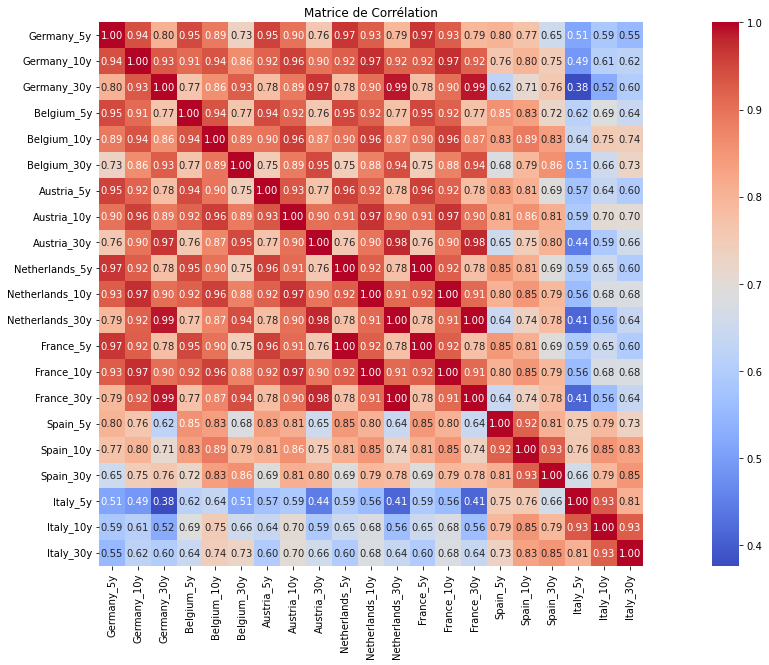

In [78]:
corr = data_manager.data.diff(5).corr()

plt.figure(figsize=(25, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.title('Matrice de Corrélation')
plt.show()

In [79]:
data_manager.data.diff(5).corr().sum().sort_values(ascending=False).head(5)

Belgium_10y        18.383139
Austria_10y        18.381252
Netherlands_10y    18.370138
France_10y         18.370138
Germany_10y        18.012549
dtype: float64

It's not best practice because it doesn't represent the exact correlations we're interested in, as there hasn't been a data shift yet, but it's a first approximation of the assets we'll try to predict. The list above provides an initial set of candidates.

To improve this method, I will run regressions on a reduced dataset (to avoid having poor predictors). I will set the Y value as the difference in yield over the next 5 days, and in the dataset, I will include the difference in yield over the last 5 days for other assets.

I will perform a linear regression for each asset to see which one is best predicted; it will serve as the asset for future tests.

In [80]:
start_date = '2016-01-01'
end_date =  '2017-03-01'
model = LinearRegression()

asset_selector = AssetSelectioByModel(data_manager.data,start_date,end_date,model)
asset_selector.train_and_evaluate().head(10)

column     score        MSE      RMSE
6        Austria_5y  0.306721  19.441704  4.409275
7       Austria_10y  0.262507  50.070844  7.076075
0        Germany_5y  0.254458  21.471110  4.633693
2       Germany_30y  0.251393  83.933046  9.161498
14       France_30y  0.239183  83.486647  9.137103
11  Netherlands_30y  0.239183  83.486647  9.137103
1       Germany_10y  0.228937  47.620530  6.900763
13       France_10y  0.224433  46.321418  6.805984
10  Netherlands_10y  0.224433  46.321418  6.805984
8       Austria_30y  0.222282  86.872038  9.320517

This method is more scientific and better meets our actual needs, so we will start by default with the Austrian 10-year bond to begin testing the strategy.

Another parameter aspect to consider is the size of the training windows and the execution of trades. To cover this part, I have divided the dataset in many different ways (with different sizes of training and execution), in order to see on average how good the prediction was or not, so as to be able to sort them.

In [81]:
test = OptimisationTimeRegressison()
premiere_valeurs = [1, 2, 3, 6, 9, 12, 18]
seconde_valeurs = [1, 2, 3, 4, 5, 6, 9, 12]
liste_temps = [(x, y) for x in premiere_valeurs for y in seconde_valeurs]
number_to_diff = 5
column_target = "Austria_10y"
new_data = data_manager.data.diff(number_to_diff)
new_data[column_target] = new_data[column_target].shift(-number_to_diff)
new_data = new_data.dropna(0)

data1, data2 =test.find_optimal_value(new_data,liste_temps, column_target)
data1.sort_values("Test_R2", ascending=False)

Train_R2  Train_RMSE  Train_MAE    Test_R2  \
train_duration test_duration                                               
18             6              0.115304    6.537935   5.144995  -0.140369   
               12             0.115048    7.047455   5.529331  -0.226136   
               4              0.128710    6.487338   5.126958  -0.248989   
               9              0.126608    6.470395   5.097667  -0.306819   
               2              0.129858    6.321502   4.989232  -0.342443   
               3              0.127030    6.419043   5.057102  -0.345012   
               5              0.130396    6.434549   5.083002  -0.372982   
12             3              0.188070    6.253199   4.947555  -0.428913   
               5              0.197839    6.080531   4.807875  -0.481550   
               6              0.185162    6.263923   4.965161  -0.492740   
               9              0.220077    6.095738   4.844854  -0.509401   
9              4              0.259743    5.871918   4.676192  -0.514232   
12             12             0.207083    6.124454   4.821890  -0.570990   
               4              0.208466    6.086615   4.821045  -0.583417   
9              12             0.241933    6.152836   4.860908  -0.653158   
               9              0.234816    5.924015   4.706059  -0.657972   
               6              0.211859    5.998234   4.790874  -0.691314   
18             1              0.128178    6.268206   4.945806  -0.706808   
12             2              0.187583    6.043417   4.804396  -0.708047   
9              5              0.265297    5.890513   4.692453  -0.760987   
               2              0.237955    5.871992   4.677681  -0.821986   
               3              0.240579    5.993210   4.775410  -1.052496   
12             1              0.185885    6.105678   4.841330  -1.102153   
6              12             0.364996    6.000213   4.758882  -1.223145   
               5              0.367304    5.182325   4.087782  -1.248915   
9              1              0.243311    5.863101   4.664672  -1.308268   
6              4              0.369332    5.549279   4.397721  -1.344971   
               6              0.353441    5.417072   4.348475  -1.345936   
               9              0.402708    5.405420   4.353080  -1.398782   
               2              0.359653    5.355776   4.249142  -1.706306   
               3              0.363867    5.427554   4.349910  -1.772528   
3              12             0.587345    4.544491   3.625712  -1.915283   
6              1              0.360619    5.345293   4.243019  -2.425312   
3              3              0.621970    3.979461   3.194499  -2.479766   
               6              0.560314    4.250340   3.404338  -3.407818   
               5              0.655448    3.750124   3.006611  -3.846535   
               9              0.647258    3.918024   3.100938  -3.847077   
2              5              0.782512    2.604441   2.088550  -4.147267   
               2              0.812029    2.726280   2.208444  -5.949577   
3              4              0.647367    3.966030   3.160995  -5.971371   
               2              0.650945    3.688843   2.942564  -6.871093   
               1              0.645714    3.860841   3.098145  -7.123568   
2              9              0.844125    2.760926   2.140243  -7.271282   
               3              0.814128    2.668025   2.148760  -9.017178   
               1              0.807904    2.663360   2.145516  -9.350401   
               12             0.808576    3.010663   2.470178  -9.629260   
               6              0.822605    2.546124   2.079155 -11.782994   
               4              0.816224    2.915983   2.339240 -12.302837   
1              9              0.966507    1.069240   0.858052 -17.108669   
               6              0.965730    0.923892   0.775574 -24.995535   
               3              0.966747    0.983919   0.798510 -28.240258   
  

This table illustrates that linear regression is not necessarily a good tool for predicting rates. I made a compromise between the R2 score test and the average of positive R2 scores. And I came to the conclusion that I should choose (12,1), (9,1), or (6,1). In the first position, we have large training windows because, in larger windows, the model fails to calibrate and thus obtains an R2 closer to 0 during the execution phase.

One thing I did, but for the sake of report readability, I won't do here, was to plot the residuals against the predicted values to see how they looked for both the training and the execution period. This reflects that linear regression struggles to accurately predict rate values for the execution part, but it still manages to do so correctly in some cases.

My first step was to try predicting the yield value over a week using linear regression and then take a position based on the sign of the prediction. I don't have the original code I used, but I will use my new code with a judicious choice of parameters to replicate my old code.

In [82]:
asset = "Austria_5y"
number_of_day_dif = 5
perdiod_of_training = 6
period_of_trade = 1
model = LinearRegression()
triger = 0.001 


firs_attempt = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,triger)
liste_trades = firs_attempt.execution_of_strategy()

backtest_first_attempt = Backtest(liste_trades, data_manager.data)
backtest_first_attempt.gather_all_trades()
backtest_first_attempt.data_with_adjusted_index()
backtest_first_attempt.plot_p_and_l("P&L - First Attempt - Strategy 2")
backtest_first_attempt.aggregate_results()

0
Sharp Ratio                             0.46
Total Return                          1065.0
Percentage Win Trade                   0.482
Number of Trades                        1887
Worst Drawdown                        -796.0
Date of Worst Drawdown   2022-07-28 00:00:00
Annual Performance 2016                145.0
Annual Performance 2017                -99.0
Annual Performance 2018                -72.0
Annual Performance 2019                 67.0
Annual Performance 2020                706.0
Annual Performance 2021               -130.0
Annual Performance 2022                478.0
Annual Performance 2023                 14.0

We notice that this strategy is interesting because it manages to generate profit. However, it has a significant drawdown, and the money it earns is made in a very punctual manner. One thing I noticed by observing the residuals compared to the predicted values is that when predicting values close to 0, errors are systematically made. That's why, to trigger the signal, in my second version, I decided to implement a threshold.

In [83]:
asset = "Austria_5y"
number_of_day_dif = 5
perdiod_of_training = 6
period_of_trade = 1
model = LinearRegression()
triger = 2


firs_attempt = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,triger)
liste_trades = firs_attempt.execution_of_strategy()

backtest_first_attempt = Backtest(liste_trades, data_manager.data)
backtest_first_attempt.gather_all_trades()
backtest_first_attempt.data_with_adjusted_index()
backtest_first_attempt.plot_p_and_l("P&L - Thresold feature - Strategy 2")
backtest_first_attempt.aggregate_results()

0
Sharp Ratio                             0.56
Total Return                          1255.0
Percentage Win Trade                   0.495
Number of Trades                        1272
Worst Drawdown                        -689.0
Date of Worst Drawdown   2022-07-28 00:00:00
Annual Performance 2016                119.0
Annual Performance 2017                -31.0
Annual Performance 2018                -20.0
Annual Performance 2019                 46.0
Annual Performance 2020                584.0
Annual Performance 2021                -76.0
Annual Performance 2022                590.0
Annual Performance 2023                 62.0

This helps to combat the noise in predictions, but it doesn't result in a satisfactory strategy because we suffer from too significant losses. To fight against the drawdown, the first solution I thought of was to implement a stop loss; for this, I had to integrate this functionality, which was not originally included in my backtester.

In [84]:
asset = "Austria_5y"
number_of_day_dif = 5
perdiod_of_training = 6
period_of_trade = 1
model = LinearRegression()
triger = 2
stop_loss = -10


firs_attempt = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,triger,stop_loss)
liste_trades = firs_attempt.execution_of_strategy()

backtest_first_attempt = Backtest(liste_trades, data_manager.data)
backtest_first_attempt.gather_all_trades()
backtest_first_attempt.data_with_adjusted_index()
backtest_first_attempt.plot_p_and_l("P&L - Stop loss feature - Strategy 2")
backtest_first_attempt.aggregate_results()

0
Sharp Ratio                             0.89
Total Return                          1712.0
Percentage Win Trade                   0.487
Number of Trades                        1272
Worst Drawdown                        -513.0
Date of Worst Drawdown   2022-08-15 00:00:00
Annual Performance 2016                118.0
Annual Performance 2017                -20.0
Annual Performance 2018                -21.0
Annual Performance 2019                 46.0
Annual Performance 2020                597.0
Annual Performance 2021                -73.0
Annual Performance 2022                944.0
Annual Performance 2023                140.0

We achieved a result that is of much better quality by limiting losses, and we already have a strategy that benefits from a higher Sharpe ratio than the previous one. Another area for improvement is to prevent trading when the market is not volatile, as we notice that our algorithm is not necessarily good during these periods. Therefore, I created a volatility filter that does not execute the trade if the realized volatility over the last 30 days has not exceeded a certain threshold.

In [85]:
asset = "Austria_5y"
number_of_day_dif = 5
perdiod_of_training = 6
period_of_trade = 1
model = LinearRegression()
triger = 2
stop_loss = -10
var_filter = 5

firs_attempt = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,triger,stop_loss)
liste_trades = firs_attempt.execution_of_strategy()

trade_filter = TradeFilter(liste_trades, var_filter)
liste_trades = trade_filter.filter_by_vol(
    data_manager.data_std_30D_by_country["Austria"])

backtest_first_attempt = Backtest(liste_trades, data_manager.data)
backtest_first_attempt.gather_all_trades()
backtest_first_attempt.data_with_adjusted_index()
backtest_first_attempt.plot_p_and_l("P&L - Variance filter feature - Strategy 2")
backtest_first_attempt.aggregate_results()

0
Sharp Ratio                             0.76
Total Return                          1371.0
Percentage Win Trade                   0.498
Number of Trades                         765
Worst Drawdown                        -513.0
Date of Worst Drawdown   2022-08-15 00:00:00
Annual Performance 2016                 86.0
Annual Performance 2017                -59.0
Annual Performance 2018                 22.0
Annual Performance 2019                  1.0
Annual Performance 2020                466.0
Annual Performance 2021                -12.0
Annual Performance 2022                752.0
Annual Performance 2023                140.0

This idea of a filter doesn't seem as good after all. Another idea I had was to test this model with other ML models to see if it would perform better.

In [86]:
dict_model ={"lin_reg" : LinearRegression(), "ridge":Ridge(),"lasso": Lasso(),"rand_for": RandomForestRegressor(), "xgb":xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)}
asset = "Austria_5y"
number_of_day_dif = 5
perdiod_of_training = 6
period_of_trade = 1
triger = 3
stop_loss = -10


list_of_strategy = []
list_of_strategy_name = []

for model_name, model_to_test in dict_model.items():
    strategy = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model_to_test,triger,stop_loss)
    liste_trades = strategy.execution_of_strategy()
    
    title = f"Profit and Loss - {model_name} - Strategy 2"
    backtest_different_model = Backtest(liste_trades, data_manager.data)
    backtest_different_model.gather_all_trades()
    backtest_different_model.data_with_adjusted_index()
    backtest_different_model.plot_p_and_l(title)
    list_of_strategy.append(backtest_different_model)
    list_of_strategy_name.append(f"{model_name}")


comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()


lin_reg                ridge  \
Sharp Ratio                             0.72                 0.73   
Total Return                          1325.0               1328.0   
Percentage Win Trade                    0.48                0.481   
Number of Trades                        1046                 1040   
Worst Drawdown                        -561.0               -561.0   
Date of Worst Drawdown   2022-08-15 00:00:00  2022-08-15 00:00:00   
Annual Performance 2016                 63.0                 58.0   
Annual Performance 2017                 -4.0                 -4.0   
Annual Performance 2018                -65.0                -65.0   
Annual Performance 2019                 30.0                 32.0   
Annual Performance 2020                585.0                589.0   
Annual Performance 2021               -107.0               -105.0   
Annual Performance 2022                708.0                708.0   
Annual Performance 2023                157.0                157.0   

                                       lasso             rand_for  \
Sharp Ratio                             0.74                  0.9   
Total Return                          1155.0               1474.0   
Percentage Win Trade                   0.489                0.517   
Number of Trades                         660                  662   
Worst Drawdown                        -417.0               -364.0   
Date of Worst Drawdown   2022-08-15 00:00:00  2022-08-15 00:00:00   
Annual Performance 2016                 12.0                 28.0   
Annual Performance 2017                -40.0                  8.0   
Annual Performance 2018               -147.0                  6.0   
Annual Performance 2019                -11.0                 -7.0   
Annual Performance 2020                237.0                268.0   
Annual Performance 2021                -67.0                -54.0   
Annual Performance 2022               1055.0               1232.0   
Annual Performance 2023                157.0                 88.0   

                                         xgb  
Sharp Ratio                             0.91  
Total Return                          1310.0  
Percentage Win Trade                   0.491  
Number of Trades                         876  
Worst Drawdown                        -237.0  
Date of Worst Drawdown   2019-06-07 00:00:00  
Annual Performance 2016                 45.0  
Annual Performance 2017                -20.0  
Annual Performance 2018                 20.0  
Annual Performance 2019                -47.0  
Annual Performance 2020                261.0  
Annual Performance 2021                -45.0  
Annual Performance 2022               1094.0  
Annual Performance 2023                 87.0

We notice that XGBoost outperforms the other models in terms of Sharpe ratio. However, it is not the one with the best final yield, but it is the one with the smallest drawdown. An interesting aspect is that, except for the random forest, we have a win trade percentage of less than 50%. This means that we often predict the direction of the trade less accurately, but we predict significant upward movements better.

### **Fine Tuning**
Let's fine-tune the parameters one at a time. I've chosen this method because it saves more time compared to conducting a grid search. We will fine-tune using a restricted dataset available up until January 1, 2018. 

First, let's attempt to fine-tune the **threshold**.

In [87]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
end_date = pd.to_datetime("2018-01-01")

asset = "Austria_5y"
number_of_day_dif = 5
perdiod_of_training = 6
period_of_trade = 1
stop_loss = -10
list_trigger = [0.1, 0.5,1,2,3,4,5,7,10]
list_of_strategy = []
list_of_strategy_name = []

for trigger in tqdm(list_trigger):
    strategy = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,trigger,stop_loss,end_date=end_date)
    liste_trades = strategy.execution_of_strategy()
    
    title = f"{trigger} trig"
    backtest_different_model = Backtest(liste_trades, data_manager.data)
    backtest_different_model.gather_all_trades()
    backtest_different_model.data_with_adjusted_index()
    list_of_strategy.append(backtest_different_model)
    list_of_strategy_name.append(title)


comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:11<00:00,  1.32s/it]


0.1 trig             0.5 trig  \
Sharp Ratio                            -0.42                -0.31   
Total Return                          -107.0                -78.0   
Percentage Win Trade                   0.443                0.446   
Number of Trades                         397                  363   
Worst Drawdown                        -245.0               -222.0   
Date of Worst Drawdown   2017-10-25 00:00:00  2017-10-25 00:00:00   
Annual Performance 2016                -13.0                -14.0   
Annual Performance 2017                -65.0                -36.0   
Annual Performance 2018                -23.0                -23.0   

                                      1 trig               2 trig  \
Sharp Ratio                            -0.39                 0.07   
Total Return                           -92.0                 16.0   
Percentage Win Trade                   0.449                0.476   
Number of Trades                         321                  248   
Worst Drawdown                        -227.0               -207.0   
Date of Worst Drawdown   2017-10-25 00:00:00  2017-10-25 00:00:00   
Annual Performance 2016                -12.0                 59.0   
Annual Performance 2017                -56.0                -27.0   
Annual Performance 2018                -21.0                -14.0   

                                      3 trig               4 trig  \
Sharp Ratio                             0.16                -0.48   
Total Return                            29.0                -66.0   
Percentage Win Trade                   0.486                0.419   
Number of Trades                         177                  117   
Worst Drawdown                        -172.0               -193.0   
Date of Worst Drawdown   2017-10-25 00:00:00  2017-10-25 00:00:00   
Annual Performance 2016                 45.0                 15.0   
Annual Performance 2017                -20.0                -83.0   
Annual Performance 2018                  5.0                  3.0   

                                      5 trig               7 trig  \
Sharp Ratio                            -0.67                -0.33   
Total Return                           -67.0                -14.0   
Percentage Win Trade                   0.409                 0.45   
Number of Trades                          66                   20   
Worst Drawdown                        -107.0                -47.0   
Date of Worst Drawdown   2017-11-07 00:00:00  2017-11-07 00:00:00   
Annual Performance 2016                 -9.0                 23.0   
Annual Performance 2017                -65.0                -37.0   
Annual Performance 2018                  8.0                  0.0   

                                     10 trig  
Sharp Ratio                            -0.15  
Total Return                            -2.0  
Percentage Win Trade                     0.5  
Number of Trades                           4  
Worst Drawdown                         -14.0  
Date of Worst Drawdown   2017-06-15 00:00:00  
Annual Performance 2016                  NaN  
Annual Performance 2017                 -2.0  
Annual Performance 2018                  0.0

Here, the results are not very convincing. Let's set the threshold to 3, as it has the highest Sharpe ratio.

Now, let's fine tune the **number of delta in days** that we are trying to predict. 

In [88]:
trigger = 3
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
end_date = pd.to_datetime("2018-01-01")


number_of_day_dif_list = [5,10,20]
asset = "Austria_5y"
perdiod_of_training = 6
period_of_trade = 1
stop_loss = -10


list_of_strategy = []
list_of_strategy_name = []

for number_of_day_dif in tqdm(number_of_day_dif_list):
    strategy = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,trigger,stop_loss,end_date=end_date)
    liste_trades = strategy.execution_of_strategy()
    
    title = f"{number_of_day_dif} day_dif"
    backtest_different_model = Backtest(liste_trades, data_manager.data)
    backtest_different_model.gather_all_trades()
    backtest_different_model.data_with_adjusted_index()
    list_of_strategy.append(backtest_different_model)
    list_of_strategy_name.append(title)


comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

100%|██████████| 3/3 [00:03<00:00,  1.28s/it]


5 day_dif           10 day_dif  \
Sharp Ratio                             0.16                 0.45   
Total Return                            29.0                153.0   
Percentage Win Trade                   0.486                0.513   
Number of Trades                         177                  238   
Worst Drawdown                        -172.0               -243.0   
Date of Worst Drawdown   2017-10-25 00:00:00  2017-07-06 00:00:00   
Annual Performance 2016                 45.0                 -9.0   
Annual Performance 2017                -20.0                120.0   
Annual Performance 2018                  5.0                 48.0   

                                  20 day_dif  
Sharp Ratio                             1.37  
Total Return                           865.0  
Percentage Win Trade                   0.537  
Number of Trades                         257  
Worst Drawdown                        -195.0  
Date of Worst Drawdown   2017-02-24 00:00:00  
Annual Performance 2016                 46.0  
Annual Performance 2017                976.0  
Annual Performance 2018               -161.0

Here, we achieve a really good Sharpe ratio with a delta of 20 days.

Let's fine-tune the duration of **training time** in months prior to execution.

In [89]:
number_of_day_dif = 20
trigger = 3
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
end_date = pd.to_datetime("2018-01-01")


asset = "Austria_5y"
perdiod_of_training_list = [1,3,6,9,12]
period_of_trade = 1
stop_loss = -10
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

list_of_strategy = []
list_of_strategy_name = []

for perdiod_of_training in tqdm(perdiod_of_training_list):
    strategy = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,trigger,stop_loss,end_date=end_date)
    liste_trades = strategy.execution_of_strategy()
    
    title = f"{perdiod_of_training} size_train"
    backtest_different_model = Backtest(liste_trades, data_manager.data)
    backtest_different_model.gather_all_trades()
    backtest_different_model.data_with_adjusted_index()
    list_of_strategy.append(backtest_different_model)
    list_of_strategy_name.append(title)


comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:07<00:00,  1.49s/it]


1 size_train         3 size_train  \
Sharp Ratio                             1.19                 1.34   
Total Return                           989.0               1014.0   
Percentage Win Trade                   0.543                0.552   
Number of Trades                         339                  319   
Worst Drawdown                        -374.0               -358.0   
Date of Worst Drawdown   2017-01-26 00:00:00  2017-02-08 00:00:00   
Annual Performance 2016                -98.0                  8.0   
Annual Performance 2017                748.0               1197.0   
Annual Performance 2018                352.0               -195.0   

                                6 size_train         9 size_train  \
Sharp Ratio                             1.37                 1.84   
Total Return                           865.0               1039.0   
Percentage Win Trade                   0.537                0.584   
Number of Trades                         257                  231   
Worst Drawdown                        -195.0               -391.0   
Date of Worst Drawdown   2017-02-24 00:00:00  2017-02-24 00:00:00   
Annual Performance 2016                 46.0                166.0   
Annual Performance 2017                976.0                864.0   
Annual Performance 2018               -161.0                 -7.0   

                               12 size_train  
Sharp Ratio                             2.44  
Total Return                          1025.0  
Percentage Win Trade                   0.621  
Number of Trades                         177  
Worst Drawdown                        -184.0  
Date of Worst Drawdown   2017-09-07 00:00:00  
Annual Performance 2016                  NaN  
Annual Performance 2017               1194.0  
Annual Performance 2018               -169.0

Here, we achieve a really good Sharpe ratio with a training time of 12 months. We need to pay attention to not overfit.

Let's fine tune the **stop loss** parameter.


In [90]:
trigger = 3
number_of_day_dif = 20
perdiod_of_training= 12
period_of_trade = 1
end_date = pd.to_datetime("2018-01-01")



asset = "Austria_5y"
stop_loss_list =  [-3,-5,-7,-10,-20]
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)

list_of_strategy = []
list_of_strategy_name = []

for stop_loss in tqdm(stop_loss_list):
    strategy = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,trigger,stop_loss,end_date=end_date)
    liste_trades = strategy.execution_of_strategy()
    
    title = f"{stop_loss} stoploss"
    backtest_different_model = Backtest(liste_trades, data_manager.data)
    backtest_different_model.gather_all_trades()
    backtest_different_model.data_with_adjusted_index()
    list_of_strategy.append(backtest_different_model)
    list_of_strategy_name.append(title)


comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


-3 stoploss          -5 stoploss  \
Sharp Ratio                             1.94                 1.94   
Total Return                           616.0                689.0   
Percentage Win Trade                   0.412                0.475   
Number of Trades                         177                  177   
Worst Drawdown                        -118.0               -130.0   
Date of Worst Drawdown   2017-04-27 00:00:00  2017-09-07 00:00:00   
Annual Performance 2017                720.0                808.0   
Annual Performance 2018               -104.0               -119.0   

                                 -7 stoploss         -10 stoploss  \
Sharp Ratio                             2.01                 2.44   
Total Return                           789.0               1025.0   
Percentage Win Trade                   0.537                0.621   
Number of Trades                         177                  177   
Worst Drawdown                        -169.0               -184.0   
Date of Worst Drawdown   2017-09-07 00:00:00  2017-09-07 00:00:00   
Annual Performance 2017                926.0               1194.0   
Annual Performance 2018               -137.0               -169.0   

                                -20 stoploss  
Sharp Ratio                             2.34  
Total Return                          1068.0  
Percentage Win Trade                   0.661  
Number of Trades                         177  
Worst Drawdown                        -287.0  
Date of Worst Drawdown   2018-02-02 00:00:00  
Annual Performance 2017               1340.0  
Annual Performance 2018               -272.0

The stop loss -10 is the one that get the best sharp ratio.

### **Testing on the Entire Dataset**

I will test the strategy on the entire dataset using the parameter values that I have identified.

In [91]:
trigger = 3
number_of_day_dif = 20
perdiod_of_training= 12
period_of_trade = 1
stop_loss=  -10
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)




list_asset = [ "Austria_5y","Austria_10y","Germany_5y","Germany_30y","France_30y","Netherlands_30y","Germany_10y"]

list_of_strategy = []
list_of_strategy_name = []

for asset in tqdm(list_asset):
    strategy = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,trigger,stop_loss)
    liste_trades = strategy.execution_of_strategy()
    
    title = f"{asset}"
    backtest_different_model = Backtest(liste_trades, data_manager.data)
    backtest_different_model.gather_all_trades()
    backtest_different_model.data_with_adjusted_index()
    list_of_strategy.append(backtest_different_model)
    list_of_strategy_name.append(title)


comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

100%|██████████| 7/7 [02:13<00:00, 19.11s/it]


Austria_5y          Austria_10y  \
Sharp Ratio                             0.49                 0.35   
Total Return                          2288.0               1668.9   
Percentage Win Trade                   0.458                0.452   
Number of Trades                        1316                 1361   
Worst Drawdown                       -1644.0              -1638.9   
Date of Worst Drawdown   2022-10-04 00:00:00  2023-07-18 00:00:00   
Annual Performance 2017               1194.0                524.8   
Annual Performance 2018               -709.0               -519.8   
Annual Performance 2019               -447.0               -127.9   
Annual Performance 2020                842.0                758.2   
Annual Performance 2021                 16.0                368.2   
Annual Performance 2022               2145.0               1919.4   
Annual Performance 2023               -542.0              -1059.9   

                                  Germany_5y          Germany_30y  \
Sharp Ratio                             0.38                 0.29   
Total Return                          1512.0               1296.0   
Percentage Win Trade                   0.466                0.441   
Number of Trades                        1250                 1364   
Worst Drawdown                       -1980.9              -1415.4   
Date of Worst Drawdown   2023-07-24 00:00:00  2022-10-04 00:00:00   
Annual Performance 2017               1081.2                698.5   
Annual Performance 2018               -211.8               -140.9   
Annual Performance 2019               -145.1                312.4   
Annual Performance 2020                499.1                262.1   
Annual Performance 2021                216.3                 27.6   
Annual Performance 2022                971.5                964.9   
Annual Performance 2023               -730.9               -676.2   

                                  France_30y      Netherlands_30y  \
Sharp Ratio                             0.31                 0.31   
Total Return                          1351.8               1351.8   
Percentage Win Trade                    0.45                 0.45   
Number of Trades                        1405                 1405   
Worst Drawdown                       -1192.3              -1192.3   
Date of Worst Drawdown   2023-07-18 00:00:00  2023-07-18 00:00:00   
Annual Performance 2017                600.7                600.7   
Annual Performance 2018                 29.2                 29.2   
Annual Performance 2019                113.5                113.5   
Annual Performance 2020                200.9                200.9   
Annual Performance 2021                247.8                247.8   
Annual Performance 2022               1185.5               1185.5   
Annual Performance 2023               -829.5               -829.5   

                                 Germany_10y  
Sharp Ratio                             0.28  
Total Return                          1221.6  
Percentage Win Trade                   0.442  
Number of Trades                        1370  
Worst Drawdown                       -1398.3  
Date of Worst Drawdown   2023-08-08 00:00:00  
Annual Performance 2017                974.8  
Annual Performance 2018               -617.8  
Annual Performance 2019                 99.1  
Annual Performance 2020                257.9  
Annual Performance 2021                160.4  
Annual Performance 2022               1385.7  
Annual Performance 2023               -850.1

In [92]:
comparator.plot_everything()

It's evident that the strategies for the most promising assets are not particularly impressive.

In this fine-tuning section, I permit myself to adjust only one parameter, guided by intuition. I am going to change the **training period** to 1 month, which better captures regime changes. By reducing the training period, I aim to create strategies that are more responsive to market dynamics. Let's examine the impact.

In [105]:
trigger = 3
number_of_day_dif = 20
perdiod_of_training= 1
period_of_trade = 1
stop_loss=  -10
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)




list_asset = [ "Austria_5y","Austria_10y","Germany_5y","Germany_30y","France_30y","Netherlands_30y","Germany_10y"]

list_of_strategy = []
list_of_strategy_name = []

for asset in tqdm(list_asset):
    strategy = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,trigger,stop_loss)
    liste_trades = strategy.execution_of_strategy()
    
    title = f"{asset}"
    backtest_different_model = Backtest(liste_trades, data_manager.data)
    backtest_different_model.gather_all_trades()
    backtest_different_model.data_with_adjusted_index()
    list_of_strategy.append(backtest_different_model)
    list_of_strategy_name.append(title)


comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()

100%|██████████| 7/7 [03:02<00:00, 26.03s/it]


Austria_5y          Austria_10y  \
Sharp Ratio                             0.92                  1.0   
Total Return                          6212.0               7134.1   
Percentage Win Trade                   0.564                0.527   
Number of Trades                        1522                 1746   
Worst Drawdown                       -1316.0              -1248.2   
Date of Worst Drawdown   2023-02-02 00:00:00  2020-06-05 00:00:00   
Annual Performance 2016                -98.0                114.8   
Annual Performance 2017                748.0                378.9   
Annual Performance 2018               1034.0                597.8   
Annual Performance 2019                835.0               1679.2   
Annual Performance 2020                -86.0               -167.0   
Annual Performance 2021                618.0               1025.0   
Annual Performance 2022               3034.0               3987.9   
Annual Performance 2023                236.0               -348.8   

                                  Germany_5y          Germany_30y  \
Sharp Ratio                             0.91                 0.94   
Total Return                          5595.4               6876.6   
Percentage Win Trade                    0.54                0.543   
Number of Trades                        1531                 1793   
Worst Drawdown                       -1197.8              -1339.4   
Date of Worst Drawdown   2023-02-02 00:00:00  2023-02-02 00:00:00   
Annual Performance 2016                -26.5                428.9   
Annual Performance 2017               1045.0                774.0   
Annual Performance 2018                884.2                179.3   
Annual Performance 2019                715.7               1977.3   
Annual Performance 2020                -61.8                175.3   
Annual Performance 2021                461.0               1245.2   
Annual Performance 2022               2410.1               2443.2   
Annual Performance 2023                158.4               -239.9   

                                  France_30y      Netherlands_30y  \
Sharp Ratio                             0.96                 0.96   
Total Return                          7049.6               7049.6   
Percentage Win Trade                   0.539                0.539   
Number of Trades                        1802                 1802   
Worst Drawdown                       -1382.2              -1382.2   
Date of Worst Drawdown   2023-02-02 00:00:00  2023-02-02 00:00:00   
Annual Performance 2016                431.8                431.8   
Annual Performance 2017                753.1                753.1   
Annual Performance 2018                122.2                122.2   
Annual Performance 2019               1854.3               1854.3   
Annual Performance 2020               -174.7               -174.7   
Annual Performance 2021               1179.8               1179.8   
Annual Performance 2022               3120.5               3120.5   
Annual Performance 2023               -124.2               -124.2   

                                 Germany_10y  
Sharp Ratio                             0.82  
Total Return                          5465.2  
Percentage Win Trade                   0.526  
Number of Trades                        1661  
Worst Drawdown                       -1322.2  
Date of Worst Drawdown   2020-04-30 00:00:00  
Annual Performance 2016               -177.4  
Annual Performance 2017                845.2  
Annual Performance 2018                465.3  
Annual Performance 2019               1164.1  
Annual Performance 2020               -185.1  
Annual Performance 2021                939.6  
Annual Performance 2022               2817.8  
Annual Performance 2023               -255.9

In [106]:
comparator.plot_everything()

The difference in performance is really huge. We obtain strategies that are now interesting.

In [107]:
comparator.calculate_correlations()

Austria_5y  Austria_10y  Germany_5y  Germany_30y  France_30y  \
Austria_5y         1.000000     0.992371    0.994072     0.969618    0.984106   
Austria_10y        0.992371     1.000000    0.982236     0.980909    0.993936   
Germany_5y         0.994072     0.982236    1.000000     0.970986    0.979416   
Germany_30y        0.969618     0.980909    0.970986     1.000000    0.993727   
France_30y         0.984106     0.993936    0.979416     0.993727    1.000000   
Netherlands_30y    0.984106     0.993936    0.979416     0.993727    1.000000   
Germany_10y        0.992636     0.995192    0.989312     0.985576    0.994270   

                 Netherlands_30y  Germany_10y  
Austria_5y              0.984106     0.992636  
Austria_10y             0.993936     0.995192  
Germany_5y              0.979416     0.989312  
Germany_30y             0.993727     0.985576  
France_30y              1.000000     0.994270  
Netherlands_30y         1.000000     0.994270  
Germany_10y             0.994270     1.000000

As expected, all these strategies are highly correlated. This is not good for diversification of risks

### **Improvement:**
- Implement a selection process for the assets to be predicted, utilizing the Rscore from each training session to potentially enhance the predictive method's accuracy.
- Explore the operation of a bond portfolio to potentially diminish the total variance, providing a clearer understanding of its mechanics.
- Enhance the fine-tuning process by establishing an ongoing refinement of the algorithm, ensuring its adaptability and improved performance over time.

# **Correlation between the two strategies**

In [112]:
list_of_strategy = []
list_of_strategy_name = []


########FIRST STRATEGY
data_spread_yield = data_manager.spread_yield
data_spread_yield[(data_spread_yield.index >= "2016-03-15") & (data_spread_yield.index <= "2023-08-28")]
time_to_keep_if_not_cross=80

cross_strategy = StrategyCrossYield(data_spread_yield,time_to_keep_if_not_cross)
liste_trades = cross_strategy.execution_of_strategy()
backtest_cross_strategy = Backtest(liste_trades, data_manager.data)
backtest_cross_strategy.gather_all_trades()
list_of_strategy.append(backtest_cross_strategy)
list_of_strategy_name.append("Strategy 1")

########SECOND STRATEGY
trigger = 3
number_of_day_dif = 20
perdiod_of_training= 1
period_of_trade = 1
stop_loss=  -10
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
list_asset =  "Austria_5y"

strategy = StrategyLinearRegressionMultiAgent(asset,number_of_day_dif,data_manager.data,perdiod_of_training,period_of_trade,model,trigger,stop_loss)
liste_trades = strategy.execution_of_strategy()
backtest_different_model = Backtest(liste_trades, data_manager.data)
backtest_different_model.gather_all_trades()
backtest_different_model.data_with_adjusted_index()
list_of_strategy.append(backtest_different_model)
list_of_strategy_name.append("Strategy 2")


In [114]:
comparator = StratgiesComparetor(list_of_strategy,list_of_strategy_name)
comparator.compare_results_of_strategies()


Strategy 1           Strategy 2
Sharp Ratio                             0.77                 0.82
Total Return                          3063.8               5465.2
Percentage Win Trade                   0.768                0.526
Number of Trades                        1131                 1661
Worst Drawdown                       -1049.7              -1322.2
Date of Worst Drawdown   2018-05-29 00:00:00  2020-04-30 00:00:00
Annual Performance 2016                446.6               -177.4
Annual Performance 2017                222.0                845.2
Annual Performance 2018                184.0                465.3
Annual Performance 2019                219.8               1164.1
Annual Performance 2020                446.6               -185.1
Annual Performance 2021                 62.2                939.6
Annual Performance 2022                855.6               2817.8
Annual Performance 2023                574.2               -255.9
Annual Performance 2024                 55.2                  NaN

In [103]:
comparator.calculate_correlations()

Strategy 1  Strategy 2
Strategy 1    1.000000    0.957498
Strategy 2    0.957498    1.000000

The strategies remain highly correlated with each other, albeit less so than before. This is not surprising, as the two P&L curves clearly follow the same trajectories.

In [111]:
comparator.plot_everything()

# Global Improvement

### Economic Data to Further Enhance Analysis:

- Inflation
- Unemployment
- GDP (Gross Domestic Product)
- Consumer Price Index (CPI)
- Producer Price Index (PPI)
- Trade Balance
- Stock Market Indices
- Market Sentiment Indicators

### Backtester

- Implement multithreading to speed up parameter search time